In [125]:
import numpy as np
import matplotlib.pyplot as plt

In [126]:
# import acceleromter data
data = np.genfromtxt(r'data/20steps.txt',delimiter=',',skip_header=25)

In [127]:
sample_rate = 20/1000 # rate in seconds


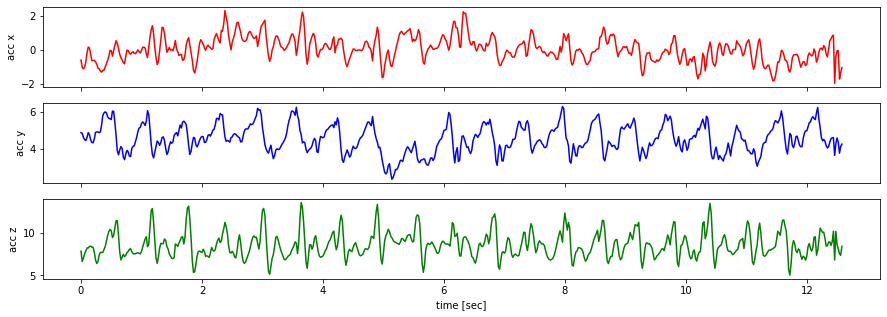

In [128]:
# plot accelerations data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(np.arange(len(data))*sample_rate,data[:,0],'-r')
axs[0].set_ylabel('acc x')

axs[1].plot(np.arange(len(data))*sample_rate,data[:,1],'-b')
axs[1].set_ylabel('acc y')

axs[2].plot(np.arange(len(data))*sample_rate,data[:,2],'-g')
axs[2].set_ylabel('acc z')

axs[2].set_xlabel('time [sec]')


plt.show()

In [129]:
# compute combined acceleromter magnitude
acc_magnitude = data[:,0]**2 + data[:,1]**2 + data[:,2]**2

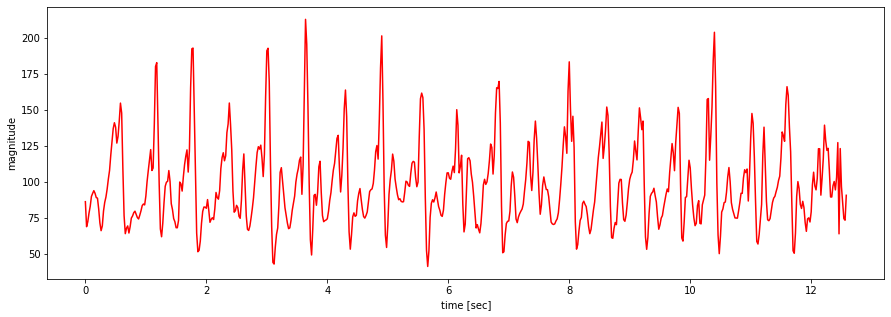

In [130]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.ylabel('magnitude')
plt.xlabel('time [sec]')
plt.show()

# Peak Detection

In [131]:
def peak_detector(data, K):
    
    peaks =[]

    for i, datum in enumerate(data):
        if i > 0:
            if i-K < 0 :
            
                if datum >= max(data[:i]) and datum >=max(data[i+1:i+K+1]):
                    peaks.append(i)
                    time_from_last_peak = 0 

            elif i+K > len(data) :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:]):
                    peaks.append(i)
                    time_from_last_peak = 0 
            else :

                if datum >= max(data[i-K:i]) and datum >=max(data[i+1:i+K+1]):
                        peaks.append(i)
                        time_from_last_peak = 0 



    return np.asarray(peaks)

In [132]:
# peak detection
K = int(0.4/sample_rate) # min distance between peaks threshold [samples]
peaks = peak_detector(acc_magnitude,K)

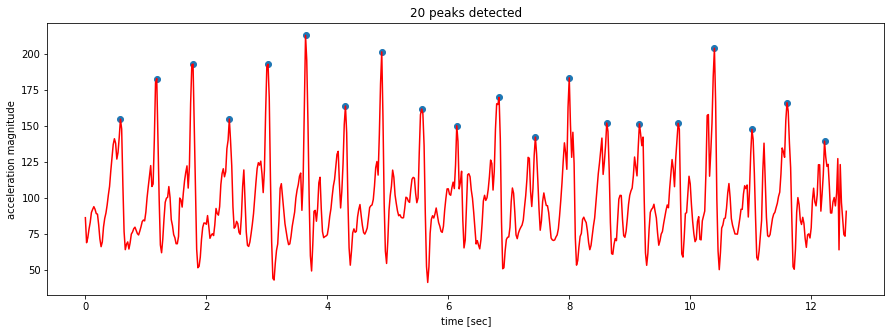

In [133]:
# plot result
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(len(acc_magnitude))*sample_rate,acc_magnitude,'-r')
plt.scatter(peaks*sample_rate,acc_magnitude[peaks])
plt.ylabel('acceleration magnitude')
plt.xlabel('time [sec]')
plt.title(str(len(peaks)) + ' peaks detected')
plt.show()

# Feature Analysis

Periodicity

In [134]:
def calculate_periodicity_thresholds(peaks, sample_rate):
    # calculate min and max time difference between neighboring peaks 

    d = np.diff(peaks)* sample_rate
    T_max = np.average(d) + 3* np.std(d)
    T_min = np.average(d) - 3* np.std(d)
    
    return T_max, T_min

In [135]:
T_max, T_min = calculate_periodicity_thresholds(peaks, sample_rate)

print('T max: ',T_max,' [sec]')
print('T min: ',T_min,' [sec]')

T max:  0.721384265417195  [sec]
T min:  0.5038788924775416  [sec]


In [136]:
def calculate_periodicity(i,peaks,sample_rate):
    # calculate min and max time difference between neighboring peaks 

    return (peaks[i] - peaks[i-1]) * sample_rate

Similarity

In [137]:
def calculate_similarity_threshold(acc_magnitude,peaks):
    # calculate similarity threshold between neighboring peaks 

    peaks_magnitude = acc_magnitude[peaks]
    d_even = np.abs(np.diff(peaks_magnitude[::2]))
    d_odd = np.abs(np.diff(peaks_magnitude[1::2]))
    d = np.vstack([d_even,d_odd])
    sim_threshold = -1*(np.average(d) + 3*np.std(d))
    
    return sim_threshold

In [138]:
sim_threshold = calculate_similarity_threshold(acc_magnitude,peaks)
print('similarity threshold: ' ,sim_threshold)

similarity threshold:  -78.06672573438564


In [139]:
def calculate_similarity(acc_magnitude,i,peaks):
    # calculate similarity  

    return -1*np.abs(acc_magnitude[peaks[i]]- acc_magnitude[peaks[i-2]])

Continuity

In [140]:
# parameters for continuity computation
M = 2 # number threshold of continuity
N = 4 # window size of continuity
var_threshold = 500 # variance threshold for motion recognition

In [141]:
def calculate_var_threshold(acc_magnitude,peaks,M,N):
    # determine continuity
    vars = []
    vars.append(np.var(acc_magnitude[0:peaks[0]]))
    for i in range(len(peaks)-1):
        vars.append(np.var(acc_magnitude[peaks[i]:peaks[i+1]]))
    vars = np.asarray(vars)
    return np.average(vars) - 3*np.std(vars)

In [142]:
var_threshold = calculate_var_threshold(acc_magnitude,peaks,M,N)
print('var threshold: ', var_threshold )

var threshold:  285.53038655167245


In [143]:
def calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold):
    # determine continuity 
    sum = 0
    for j in range(i-N+1,i+1):
        var = np.var(acc_magnitude[peaks[j]:peaks[j+1]]) 
        if var > var_threshold: # motion recognition
            sum += 1
    if sum >= M:
        C = 1
    else:
        C = 0
    return C

# Simulation

In [147]:
# running simulation with the computed parameters
steps = []
steps_count = 0
for i in range(N-1,len(peaks)-1):
    C = calculate_continuity(i,acc_magnitude,peaks,M,N,var_threshold)
    # prints for debug
    print(C)
    print(calculate_similarity(acc_magnitude,i,peaks))
    print(calculate_periodicity(i,peaks,sample_rate))
    #
    if C == 0:
        continue
    elif calculate_similarity(acc_magnitude,i,peaks)<=sim_threshold:
        continue
    elif T_min<calculate_periodicity(i,peaks,sample_rate)<T_max:
        steps_count +=1
        steps.append(peaks[i])

print('step count is: ',steps_count)



1
-27.984475000000003
0.6
1
-0.12732699999997976
0.64
1
-57.99016499999996
0.62
1
-28.954969999999975
0.66
1
-11.453825999999992
0.6
1
-2.135576000000043
0.66
1
-51.16101299999997
0.58
1
-8.094764000000026
0.7000000000000001
1
-7.899918000000014
0.6
1
-13.577661000000006
0.56
1
-9.733955000000009
0.62
1
-31.904453000000018
0.54
1
-0.2197089999999946
0.64
1
-52.390844000000016
0.6
1
-4.234865000000013
0.62
1
-37.71074100000001
0.58
step count is:  16
